In [1]:
import cv2
from matplotlib import pyplot as plt 
import numpy as np

In [2]:
Left_1 = cv2.imread('bike_l.png')
Right_1 = cv2.imread('bike_r.png')
Left_2 = cv2.imread('coaster_left.jpg')
Right_2 = cv2.imread('coaster_right.jpg')
Left_3 = cv2.imread('tape_l.jpg')
Right_3 = cv2.imread('tape_r.jpg')
left1 = cv2.cvtColor(Left_1,cv2.COLOR_RGB2GRAY)
right1 = cv2.cvtColor(Right_1,cv2.COLOR_RGB2GRAY)
left2 = cv2.cvtColor(Left_2,cv2.COLOR_RGB2GRAY)
right2 = cv2.cvtColor(Right_2,cv2.COLOR_RGB2GRAY)
left3 = cv2.cvtColor(Left_3,cv2.COLOR_RGB2GRAY)
right3 = cv2.cvtColor(Right_3,cv2.COLOR_RGB2GRAY)

## 1.1 Fundamental Matrix Calculation

In [3]:
def Fundamental_Matrix(image1,image2):
    image1 = cv2.cvtColor(image1,cv2.COLOR_BGR2RGB)
    image2 = cv2.cvtColor(image2,cv2.COLOR_BGR2RGB)
    gray1 = cv2.cvtColor(image1, cv2.COLOR_BGR2GRAY)
    gray2 = cv2.cvtColor(image2, cv2.COLOR_BGR2GRAY)
    
    my_SIFT_instance = cv2.SIFT_create()

    imgOut1 = np.copy(image1)
    imgOut2 = np.copy(image2)
    keypoints_1, descriptors_1 = my_SIFT_instance.detectAndCompute(imgOut1,None)
    keypoints_2, descriptors_2 = my_SIFT_instance.detectAndCompute(imgOut2,None)
    
    FLANN_INDEX_KDTREE = 0
    index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
    search_params = dict(checks = 50)
    feature = cv2.FlannBasedMatcher(index_params,search_params)
    matches = feature.knnMatch(descriptors_1,descriptors_2, k=2) 
    
    good = []
    p1 = []
    p2 = []
    keyp1 = []
    keyp2 = []
    for m,n in matches:
        md = m.distance
        nd = n.distance 
        ratio = md / nd
        tau = 0.75
        if md  < tau *nd :
            good.append([m])
            p1.append(keypoints_1[m.queryIdx].pt)
            p2.append(keypoints_2[m.trainIdx].pt) 
    p1 = np.int32(p1)
    p2 = np.int32(p2)
    
    f, mask = cv2.findFundamentalMat(p1, p2, cv2.RANSAC)
#     p1 = p1[mask.ravel()==1]
#     p2 = p2[mask.ravel()==1]
            
    return p1, p2,f

## 1.2 Image Rectification

In [4]:
def Image_Rectification(image1,image2):
    p1 = []
    p2 = []
    f= []
    p1,p2,f = Fundamental_Matrix(image1,image2)

#    retBool ,rectmat1, rectmat2 = cv2.stereoRectifyUncalibrated(p1.reshape(-1,1,2),p2.reshape(-1,1,2),f,(image1.shape[1], image1.shape[0]))
    retBool ,rectmat1, rectmat2 = cv2.stereoRectifyUncalibrated(p1.ravel(),p2.ravel(),f,(image1.shape[1], image1.shape[0]))
    
    return rectmat1, rectmat2

run


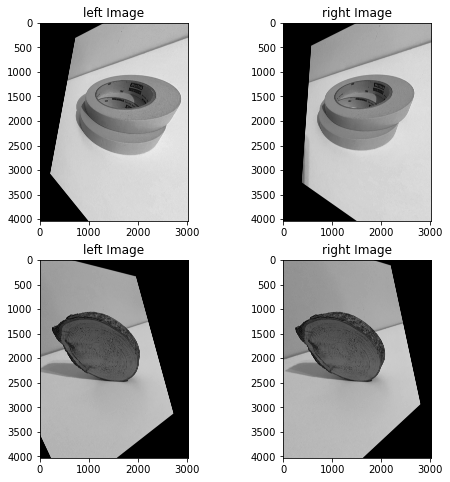

In [5]:
r1, r2 = Image_Rectification(left3,right3)
dst1 = cv2.warpPerspective(left3,r1,(left3.shape[1], left3.shape[0]))
dst2 = cv2.warpPerspective(right3,r2,(right3.shape[1], right3.shape[0]))


r3, r4 = Image_Rectification(left2,right2)
dst11 = cv2.warpPerspective(left2,r3,(left2.shape[1], left2.shape[0]))
dst22 = cv2.warpPerspective(right2,r4,(right2.shape[1], right2.shape[0]))

r5, r6 = Image_Rectification(left1,right1)
dst111 = cv2.warpPerspective(left1,r5,(left1.shape[1],left1.shape[0]))
dst222 = cv2.warpPerspective(right1,r6,(right1.shape[1],right1.shape[0]))

print("run")

plt.figure(figsize=(8,8))
plt.subplot(2,2,1)
plt.title("left Image")
plt.imshow(dst1,cmap = 'gray')

plt.subplot(2,2,2)
plt.title("right Image")
plt.imshow(dst2,cmap = 'gray')

plt.subplot(2,2,3)
plt.title("left Image")
plt.imshow(dst11,cmap = 'gray')

plt.subplot(2,2,4)
plt.title("right Image")
plt.imshow(dst22,cmap = 'gray')

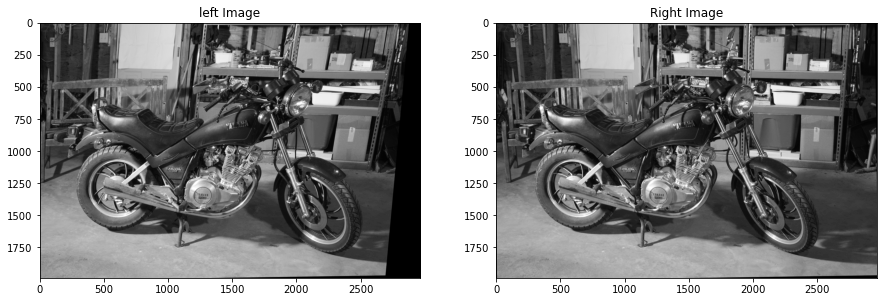

In [6]:
r5, r6 = Image_Rectification(left1,right1)
dst111 = cv2.warpPerspective(left1,r5,(left1.shape[1],left1.shape[0]))
dst222 = cv2.warpPerspective(right1,r6,(right1.shape[1],right1.shape[0]))
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.title("left Image")
plt.imshow(dst111,cmap = 'gray')

plt.subplot(1,2,2)
plt.title("Right Image")
plt.imshow(dst222,cmap = 'gray')

## 1.3 Block Matching Disparity Map Calculation

In [7]:
def  Block_Matching(image1,image2,minDisparity,numDisparities,blockSize,flag):
    # Initialize the stereo block matching object 
    if flag == 1:
        stereo = cv2.StereoSGBM_create(minDisparity, numDisparities, blockSize)
    if flag == 0:
        stereo = cv2.StereoBM_create(numDisparities, blockSize)
    # Compute the disparity image
    disparity = stereo.compute(image1,image2)
    return disparity

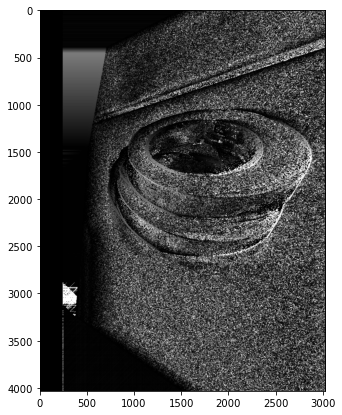

In [8]:
test2 = Block_Matching(dst1,dst2,0,240,11,1)
plt.figure(figsize=(7,7))
plt.imshow(test2,cmap = 'gray')

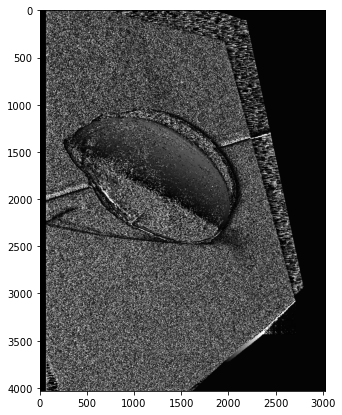

In [9]:
test4 = Block_Matching(dst11,dst22,0,64,7,1)
plt.figure(figsize=(7,7))
plt.imshow(test4,cmap = 'gray')

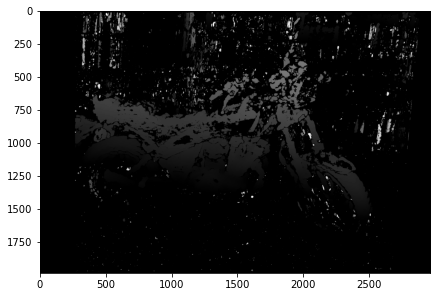

In [16]:
test6 = Block_Matching(dst111,dst222,0,256,23,0)
plt.figure(figsize=(7,7))
plt.imshow(test6,cmap = 'gray')